In [1]:
from pprint import pprint

import numpy as np
from scipy.constants import pi
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import rcParams
rcParams["font.size"] = 18

import quvac
from quvac.grid import setup_grids
from quvac.field import ANALYTIC_FIELDS, SPATIAL_MODEL_FIELDS
from quvac.field.external_field import ExternalField
from quvac.field.utils import get_intensity

In [2]:
# available analytic field configurations
pprint(ANALYTIC_FIELDS)
print()
pprint(SPATIAL_MODEL_FIELDS)

{'dipole_analytic': <class 'quvac.field.dipole.DipoleAnalytic'>,
 'paraxial_gaussian_analytic': <class 'quvac.field.gaussian.GaussianAnalytic'>}

{'dipole_maxwell': <class 'quvac.field.dipole.DipoleAnalytic'>,
 'paraxial_gaussian_maxwell': <class 'quvac.field.gaussian.GaussianAnalytic'>}


## Create one external field
Every field type has its own parameter dictionary.

Choosing the grid size, one should make it large enough to fit the field and make 
the resolution good enough to resolve the smallest scale present in the problem. When
using dynamical grid creation, one should be careful!

In [3]:
lam = 800e-9
w0 = 1 * lam
tau = 25e-15

# all parameters in SI units
field_params = {
    "field_type": "paraxial_gaussian_maxwell",
    "focus_x": [0.,0.,0.],
    "focus_t": 0.,
    "theta": 0,
    "phi": 0,
    "beta": 0,
    "phase0": 0,
    "lam": lam,
    "w0": w0,
    "tau": tau,
    "W": 25,
    "order": 0,
}

# grid parameters
grid_params = {
    'mode': 'dynamic',
    'collision_geometry': 'z',
    'transverse_factor': 20,
    'longitudinal_factor': 8,
    'time_factor': 4,
    'spatial_resolution': 2,
    'time_resolution': 1,
}

# create spatial and temporal grid
grid_xyz, grid_t = setup_grids([field_params], grid_params)
grid_xyz.get_k_grid()
print(f"Grid shape: {grid_xyz.grid_shape}")
for ax_name,ax in zip(["x", "y", "z"], grid_xyz.grid):
    x0 = ax[-1]*1e6
    print(f"    {ax_name} size: ({-x0:<6.1f}, {x0:<6.1f}) mum")

print(f"Time grid : {len(grid_t)}")
t0 = grid_t[-1]*1e15
print(f"    t size: ({-t0:<6.1f}, {t0:<6.1f}) fs")

Grid shape: (78, 78, 512)
    x size: (-7.8  , 7.8   ) mum
    y size: (-7.8  , 7.8   ) mum
    z size: (-29.9 , 29.9  ) mum
Time grid : 225
    t size: (-50.0 , 50.0  ) fs


In [4]:
# create field
field = ExternalField([field_params], grid_xyz)
E, B = field.calculate_field(t=0.)

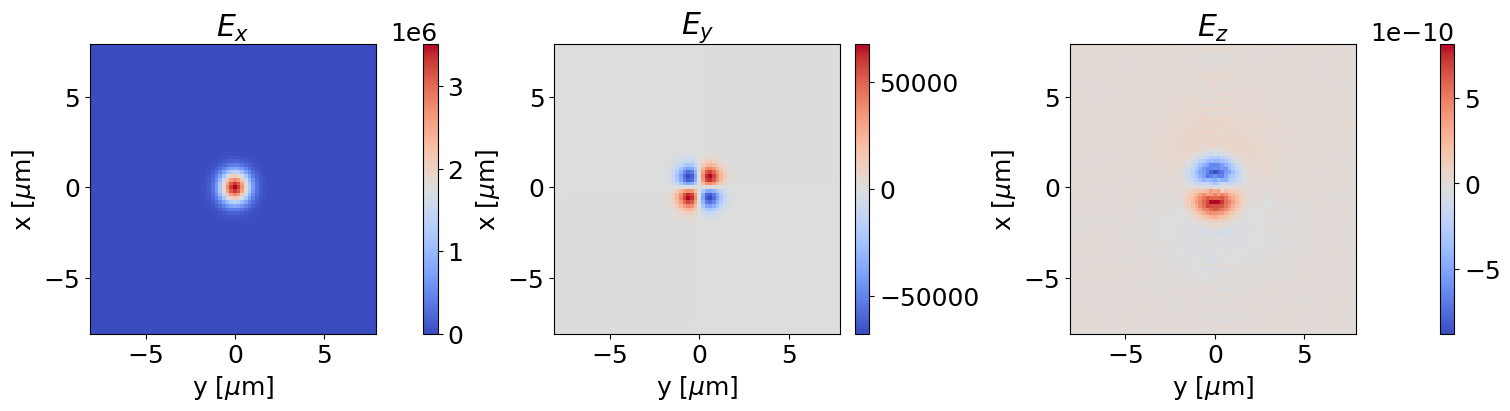

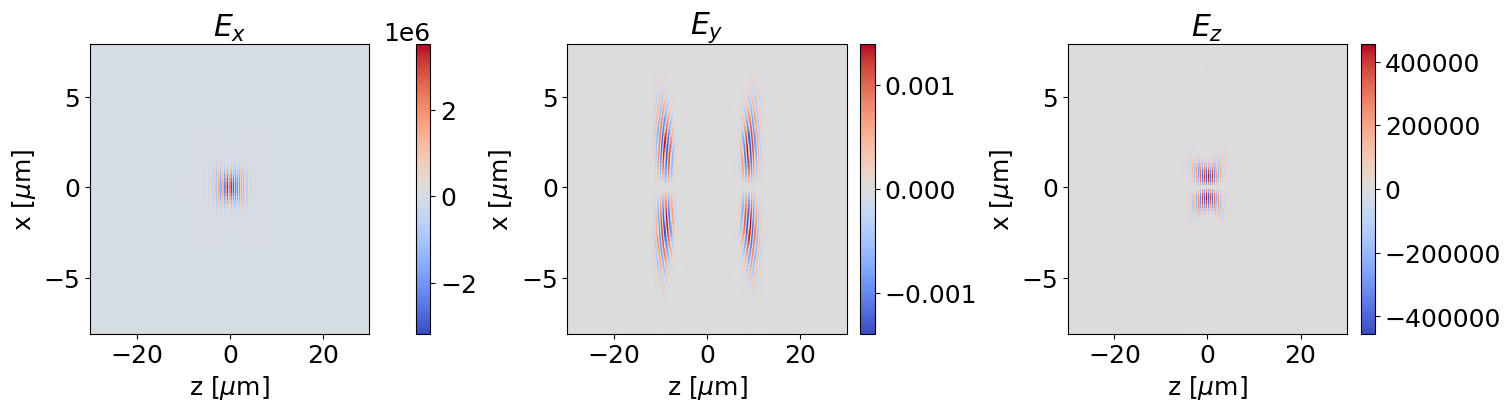

In [5]:
# plot field profiles
(Ex,Ey,Ez) = [np.real(E_) for E_ in E]
(Bx,By,Bz) = [np.real(B_) for B_ in B]
nx,ny,nz = grid_xyz.grid_shape
x,y,z = [ax*1e6 for ax in grid_xyz.grid]

titles = ["$E_x$", "$E_y$", "$E_z$"]

# transverse profile
plt.figure(figsize=(15,4), layout="constrained")
for idx,data in enumerate([Ex,Ey,Ez]):
    plt.subplot(1,3,idx+1)
    plt.pcolormesh(y, x, data[:,:,nz//2], cmap='coolwarm',
                   rasterized=True)
    plt.colorbar()
    plt.xlabel("y [$\\mu$m]")
    plt.ylabel("x [$\\mu$m]")
    plt.title(titles[idx])
plt.show()

# longitudinal profile
plt.figure(figsize=(15,4), layout="constrained")
for idx,data in enumerate([Ex,Ey,Ez]):
    plt.subplot(1,3,idx+1)
    plt.pcolormesh(z, x, data[:,ny//2,:], cmap='coolwarm',
                   rasterized=True)
    plt.colorbar()
    plt.xlabel("z [$\\mu$m]")
    plt.ylabel("x [$\\mu$m]")
    plt.title(titles[idx])
plt.show()

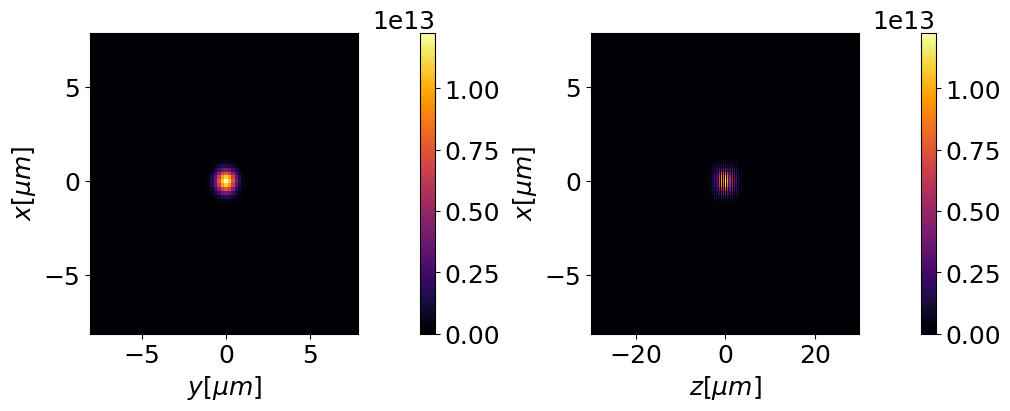

In [6]:
# plot intensity
I = get_intensity(field, t=0.)

plt.figure(figsize=(10,4), layout="constrained")
plt.subplot(1,2,1)
plt.pcolormesh(y, x, I[:,:,nz//2], cmap='inferno',
               rasterized=True)
plt.colorbar()
plt.xlabel("$y [\\mu m]$")
plt.ylabel("$x [\\mu m]$")

plt.subplot(1,2,2)
plt.pcolormesh(z, x, I[:,ny//2,:], cmap='inferno',
               rasterized=True)
plt.colorbar()
plt.xlabel("$z [\\mu m]$")
plt.ylabel("$x [\\mu m]$")
plt.show()

### Plot field spectrum in k-space
Available only for Maxwell-type fields.

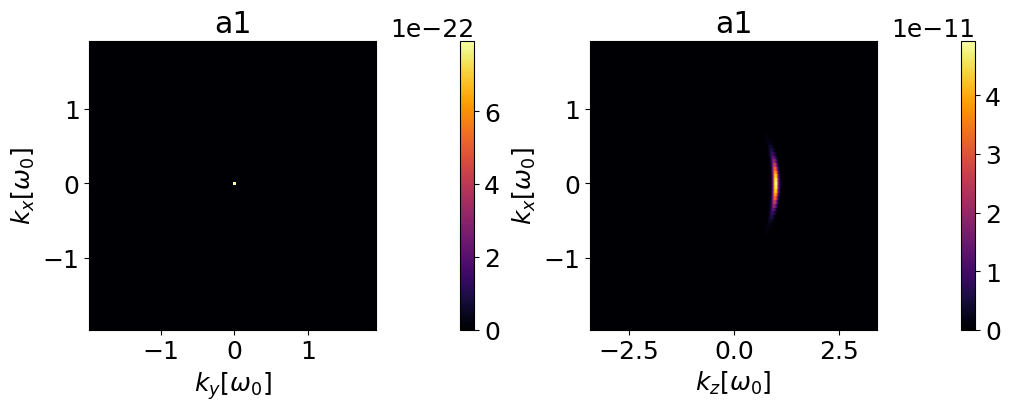

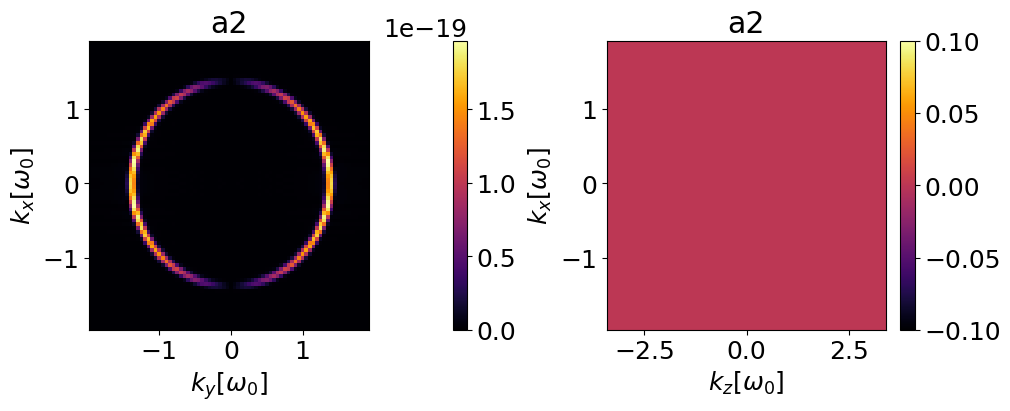

In [7]:
# Spectral coefficients
a1, a2 = [getattr(field.fields[0], key) for key in ["a1","a2"]]
a1, a2 = [np.fft.fftshift(a) for a in (a1,a2)]

k0 = 2*pi/lam
kx,ky,kz = [k/k0 for k in grid_xyz.kgrid_shifted]

for a,key in zip([a1,a2], ["a1","a2"]):
    plt.figure(figsize=(10,4), layout="constrained")
    plt.subplot(1,2,1)
    plt.pcolormesh(ky, kx, np.abs(a[:,:,nz//2]), cmap='inferno',
                   rasterized=True)
    plt.colorbar()
    plt.xlabel("$k_y [\\omega_0]$")
    plt.ylabel("$k_x [\\omega_0]$")
    plt.title(key)

    plt.subplot(1,2,2)
    plt.pcolormesh(kz, kx, np.abs(a[:,ny//2,:]), cmap='inferno',
                   rasterized=True)
    plt.colorbar()
    plt.xlabel("$k_z [\\omega_0]$")
    plt.ylabel("$k_x [\\omega_0]$")
    plt.title(key)
plt.show()

## Several external fields
One needs to add a separate dict with field parameters for each participating field.

In [8]:
lam = 800e-9
w0 = 2 * lam
tau = 25e-15

# all parameters in SI units
field_1_params = {
    "field_type": "paraxial_gaussian_maxwell",
    "focus_x": [0.,0.,0.],
    "focus_t": 0.,
    "theta": 0,
    "phi": 0,
    "beta": 0,
    "phase0": 0,
    "lam": lam,
    "w0": w0,
    "tau": tau,
    "W": 25,
    "order": 0,
}

# add counter-propagating field
field_2_params = {
    "field_type": "paraxial_gaussian_maxwell",
    "focus_x": [0.,0.,0.],
    "focus_t": 0.,
    "theta": 180,
    "phi": 0,
    "beta": 0,
    "phase0": 0,
    "lam": lam,
    "w0": w0,
    "tau": tau,
    "W": 25,
    "order": 0,
}

# combine
fields_params = {
    "field_1": field_1_params,
    "field_2": field_2_params,
}

# grid parameters
grid_params = {
    'mode': 'dynamic',
    'collision_geometry': 'z',
    'transverse_factor': 30,
    'longitudinal_factor': 8,
    'time_factor': 4,
    'spatial_resolution': 2,
    'time_resolution': 1,
}

# create spatial and temporal grid
grid_xyz, grid_t = setup_grids(fields_params, grid_params)
grid_xyz.get_k_grid()
print(f"Grid shape: {grid_xyz.grid_shape}")
for ax_name,ax in zip(["x", "y", "z"], grid_xyz.grid):
    x0 = ax[-1]*1e6
    print(f"    {ax_name} size: ({-x0:<6.1f}, {x0:<6.1f}) mum")

print(f"Time grid : {len(grid_t)}")
t0 = grid_t[-1]*1e15
print(f"    t size: ({-t0:<6.1f}, {t0:<6.1f}) fs")

nx, ny, nz = grid_xyz.grid_shape
x, y, z = [ax*1e6 for ax in grid_xyz.grid]

Grid shape: (120, 120, 512)
    x size: (-23.6 , 23.6  ) mum
    y size: (-23.6 , 23.6  ) mum
    z size: (-29.9 , 29.9  ) mum
Time grid : 225
    t size: (-50.0 , 50.0  ) fs


In [9]:
# create field
field = ExternalField(list(fields_params.values()), grid_xyz)
E, B = field.calculate_field(t=25e-15)

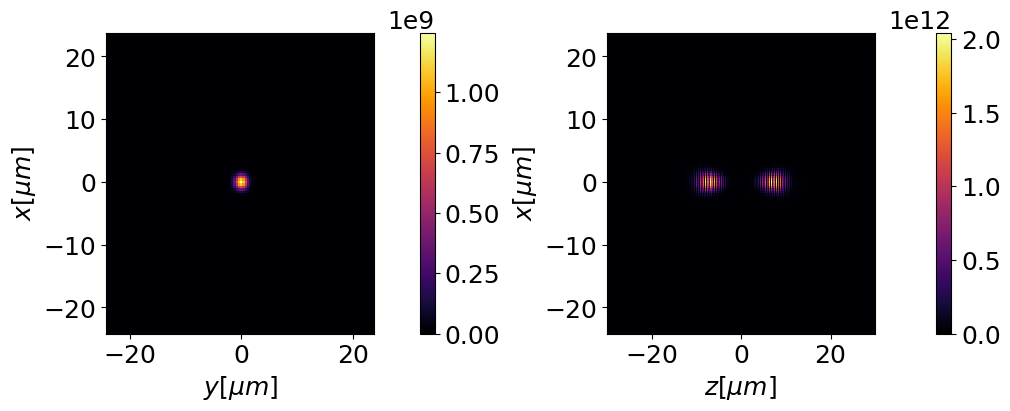

In [10]:
# plot intensity
I = get_intensity(field, t=25e-15)

norm_lim = 1e-10
plt.figure(figsize=(10,4), layout="constrained")
plt.subplot(1,2,1)
plt.pcolormesh(y, x, I[:,:,nz//2], cmap='inferno',
               rasterized=True)
plt.colorbar()
plt.xlabel("$y [\\mu m]$")
plt.ylabel("$x [\\mu m]$")

plt.subplot(1,2,2)
plt.pcolormesh(z, x, I[:,ny//2,:], cmap='inferno',
               rasterized=True)
plt.colorbar()
plt.xlabel("$z [\\mu m]$")
plt.ylabel("$x [\\mu m]$")
plt.show()

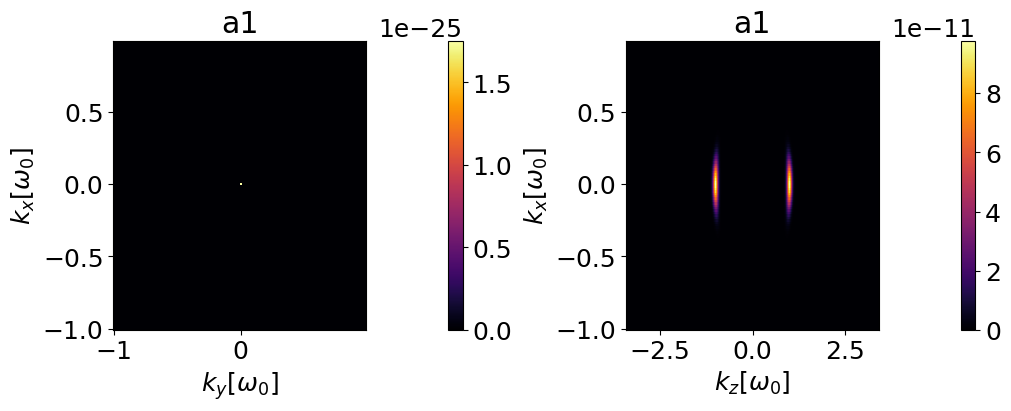

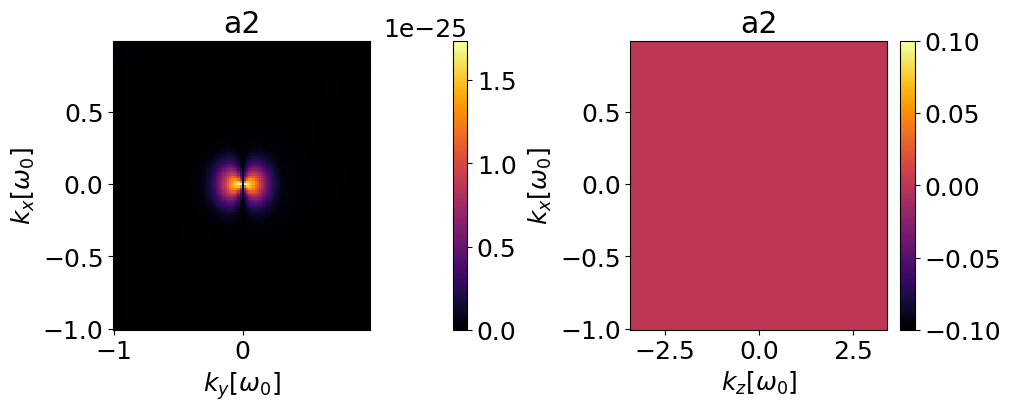

In [11]:
# Spectral coefficients
a1, a2 = [getattr(field.fields[0], key) for key in ["a1","a2"]]
a1, a2 = [np.fft.fftshift(a) for a in (a1,a2)]

k0 = 2*pi/lam
kx,ky,kz = [k/k0 for k in grid_xyz.kgrid_shifted]

for a,key in zip([a1,a2], ["a1","a2"]):
    plt.figure(figsize=(10,4), layout="constrained")
    plt.subplot(1,2,1)
    plt.pcolormesh(ky, kx, np.abs(a[:,:,nz//2]), cmap='inferno',
                   rasterized=True)
    plt.colorbar()
    plt.xlabel("$k_y [\\omega_0]$")
    plt.ylabel("$k_x [\\omega_0]$")
    plt.title(key)

    plt.subplot(1,2,2)
    plt.pcolormesh(kz, kx, np.abs(a[:,ny//2,:]), cmap='inferno',
                   rasterized=True)
    plt.colorbar()
    plt.xlabel("$k_z [\\omega_0]$")
    plt.ylabel("$k_x [\\omega_0]$")
    plt.title(key)
plt.show()